In [1]:
import yfinance as yf

In [2]:
# !pip install tensorflow

In [2]:
stock = yf.Ticker("AAPL") 
data = stock.history(start="2015-01-01", end="2025-01-01", auto_adjust=False) 

In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2015-01-02 00:00:00-05:00,27.847500,27.860001,26.837500,27.332500,24.320433,212818400,0.0,0.0
2015-01-05 00:00:00-05:00,27.072500,27.162500,26.352501,26.562500,23.635277,257142000,0.0,0.0
2015-01-06 00:00:00-05:00,26.635000,26.857500,26.157499,26.565001,23.637506,263188400,0.0,0.0
2015-01-07 00:00:00-05:00,26.799999,27.049999,26.674999,26.937500,23.968958,160423600,0.0,0.0
2015-01-08 00:00:00-05:00,27.307501,28.037500,27.174999,27.972500,24.889904,237458000,0.0,0.0


In [4]:
data.to_csv("Apple_data.csv")

In [5]:
data.shape

(2516, 8)

In [6]:
print(data.isnull().sum())


Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


In [8]:
df1 = data.reset_index()['Close']


In [9]:
df1

0        27.332500
1        26.562500
2        26.565001
3        26.937500
4        27.972500
           ...    
2511    258.200012
2512    259.019989
2513    255.589996
2514    252.199997
2515    250.419998
Name: Close, Length: 2516, dtype: float64

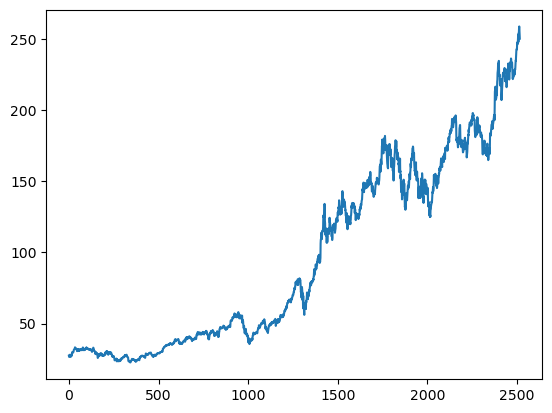

In [10]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [12]:
import numpy as np

In [14]:
training_size = int(len(df1)*0.8)
train_data = df1[:training_size]
test_data = df1[training_size:]

In [15]:
train_data.shape

(2012,)

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
train_data_scaled = scaler.fit_transform(np.array(train_data).reshape(-1,1))
test_data_scaled = scaler.transform(np.array(test_data).reshape(-1, 1))

In [13]:
# print(df1)

[[0.02007952]
 [0.01682281]
 [0.01683339]
 ...
 [0.98549287]
 [0.9711549 ]
 [0.9636264 ]]


In [17]:
print(train_data_scaled)

[[0.0297789 ]
 [0.02494904]
 [0.02496473]
 ...
 [0.68543205]
 [0.67395329]
 [0.64892586]]


In [14]:
##splitting dataset into train and test split
# training_size = int(len(df1)*0.8)
# test_size = len(df1)-training_size
# train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [15]:
# training_size, test_size

(2012, 504)

In [18]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [20]:
time_step = 100
X_train, y_train = create_dataset(train_data_scaled, time_step)
X_test, ytest = create_dataset(test_data_scaled, time_step)

In [21]:
print(X_train.shape), print(y_train.shape)

(1912, 100)
(1912,)


(None, None)

In [22]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

In [23]:
print("X_train shape:", X_train.shape)  # Expected: (samples, 100, 1)
print("X_test shape:", X_test.shape)    # Expected: (test_samples, 100, 1)

X_train shape: (1912, 100, 1)
X_test shape: (404, 100, 1)


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Input

In [26]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [22]:
# pip install numpy==1.19.5

In [27]:
model = Sequential()
# Add an Input layer to explicitly define the input shape
model.add(Input(shape=(100, 1)))  # Input shape: (time_steps, features)

# Add LSTM layers
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='Adam')

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 0.0772 - val_loss: 0.0088
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0017 - val_loss: 0.0142
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0010 - val_loss: 0.0166
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 8.9604e-04 - val_loss: 0.0111
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 9.2844e-04 - val_loss: 0.0101
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 9.8110e-04 - val_loss: 0.0117
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 8.7468e-04 - val_loss: 0.0117
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 8.9159e-04 - val_loss: 0.0098
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 9.0672e-04 - val_loss: 0.0106
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 8.2293e-04 - val_loss: 0.0081
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 8.6959e-04 - val_loss: 0.0066
Epoch 12/

In [31]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [32]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [34]:
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(ytest.reshape(-1, 1))

In [35]:
train_predict

array([[ 32.85509 ],
       [ 32.928123],
       [ 32.948887],
       ...,
       [134.04524 ],
       [132.77354 ],
       [131.31857 ]], dtype=float32)

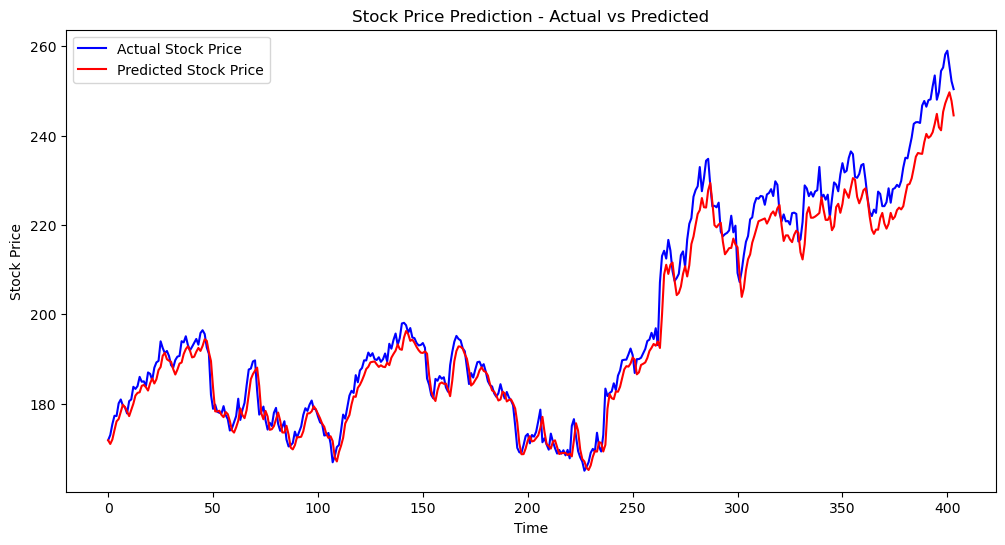

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot actual stock prices
plt.plot(y_test_actual, label='Actual Stock Price', color='blue')

# Plot predicted stock prices
plt.plot(test_predict, label='Predicted Stock Price', color='red')

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Stock Price Prediction - Actual vs Predicted')
plt.show()


In [28]:
# import math
# from sklearn.metrics import mean_squared_error

In [29]:
# math.sqrt(mean_squared_error(y_train,train_predict))

89.83561625562967

In [30]:
# math.sqrt(mean_squared_error(ytest,test_predict))

196.81270173237496

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# RMSE (Lower is better)
rmse_train = np.sqrt(mean_squared_error(y_train_actual, train_predict))
rmse_test = np.sqrt(mean_squared_error(y_test_actual, test_predict))

# MAE (Lower is better)
mae_train = mean_absolute_error(y_train_actual, train_predict)
mae_test = mean_absolute_error(y_test_actual, test_predict)

# Print results
print(f"Train RMSE: {rmse_train}")
print(f"Test RMSE: {rmse_test}")
print(f"Train MAE: {mae_train}")
print(f"Test MAE: {mae_test}")


Train RMSE: 2.057467953794308
Test RMSE: 4.4153928601929255
Train MAE: 1.3367563830259954
Test MAE: 3.407929373259591


In [40]:
# ### Plotting 
# # shift train predictions for plotting
# look_back=100
# trainPredictPlot = np.empty_like(df1)
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# # shift test predictions for plotting
# testPredictPlot = np.empty_like(df1)
# testPredictPlot[:, :] = np.nan
# testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# # plot baseline and predictions
# plt.plot(scaler.inverse_transform(df1))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()

# # Blue Line: Actual data (baseline).
# # Orange Line: Training predictions.
# # Green Line: Test predictions.

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

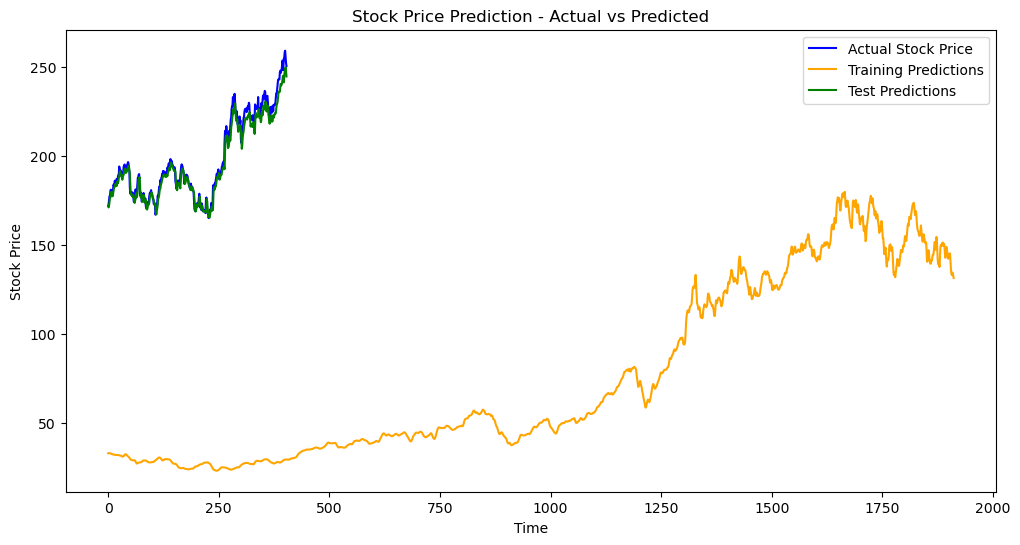

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot actual stock prices
plt.plot(y_test_actual, label="Actual Stock Price", color="blue")

# Plot training predictions
plt.plot(train_predict, label="Training Predictions", color="orange")

# Plot test predictions
plt.plot(test_predict, label="Test Predictions", color="green")

# Add title, labels, and legend
plt.title("Stock Price Prediction - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()  # Show labels on the graph
plt.show()


In [44]:
# len(test_data)

504

In [33]:
# x_input=test_data[404:].reshape(1,-1)
# x_input.shape

(1, 100)

In [34]:
# temp_input=list(x_input)
# temp_input=temp_input[0].tolist()

In [ ]:
# # demonstrate prediction for next days
# from numpy import array

# lst_output=[]
# n_steps=100
# i=0
# while(i<30):
    
#     if(len(temp_input)>100):
#         #print(temp_input)
#         x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
#         x_input=x_input.reshape(1,-1)
#         x_input = x_input.reshape((1, n_steps, 1))
#         #print(x_input)
#         yhat = model.predict(x_input, verbose=0)
#         print("{} day output {}".format(i,yhat))
#         temp_input.extend(yhat[0].tolist())
#         temp_input=temp_input[1:]
#         #print(temp_input)
#         lst_output.extend(yhat.tolist())
#         i=i+1
#     else:
#         x_input = x_input.reshape((1, n_steps,1))
#         yhat = model.predict(x_input, verbose=0)
#         print(yhat[0])
#         temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
#         lst_output.extend(yhat.tolist())
#         i=i+1
    

# print(lst_output)

In [45]:
# Use the last 100 days of test data as input
x_input = test_data_scaled[-100:].reshape(1, -1)  
temp_input = x_input.flatten().tolist()  # Convert to list

In [46]:
lst_output = []  # Store future predictions
n_steps = 100  # Time step size
i = 0

while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])  # Keep only the last 100 elements
        x_input = x_input.reshape((1, n_steps, 1))  # Reshape to (1,100,1)
        
        # Predict next day
        yhat = model.predict(x_input, verbose=0)
        print(f"{i+1} Day Prediction: {yhat[0][0]}")

        # Add the prediction to the sequence and remove the oldest value
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i += 1

# Convert predicted values back to original scale
lst_output = np.array(lst_output).reshape(-1, 1)
future_predictions = scaler.inverse_transform(lst_output)

# Print the predicted stock prices for the next 30 days
print("\nPredicted Stock Prices for the Next 30 Days:")
print(future_predictions)


2 Day Prediction: 1.3510061502456665
3 Day Prediction: 1.3179231882095337
4 Day Prediction: 1.2916179895401
5 Day Prediction: 1.268968105316162
6 Day Prediction: 1.248260736465454
7 Day Prediction: 1.2293298244476318
8 Day Prediction: 1.211877703666687
9 Day Prediction: 1.1955146789550781
10 Day Prediction: 1.180014967918396
11 Day Prediction: 1.1652860641479492
12 Day Prediction: 1.151292085647583
13 Day Prediction: 1.1380234956741333
14 Day Prediction: 1.1254831552505493
15 Day Prediction: 1.1136726140975952
16 Day Prediction: 1.102583885192871
17 Day Prediction: 1.0921975374221802
18 Day Prediction: 1.082484483718872
19 Day Prediction: 1.0734069347381592
20 Day Prediction: 1.0649235248565674
21 Day Prediction: 1.0569902658462524
22 Day Prediction: 1.0495632886886597
23 Day Prediction: 1.042600393295288
24 Day Prediction: 1.036062479019165
25 Day Prediction: 1.0299128293991089
26 Day Prediction: 1.0241183042526245
27 Day Prediction: 1.0186487436294556
28 Day Prediction: 1.01347577571

In [36]:
# day_new=np.arange(1,101)
# day_pred=np.arange(101,131)

In [37]:
import matplotlib.pyplot as plt

In [ ]:
# plt.plot(day_new,scaler.inverse_transform(df1[2416:]))
# plt.plot(day_pred,scaler.inverse_transform(lst_output))

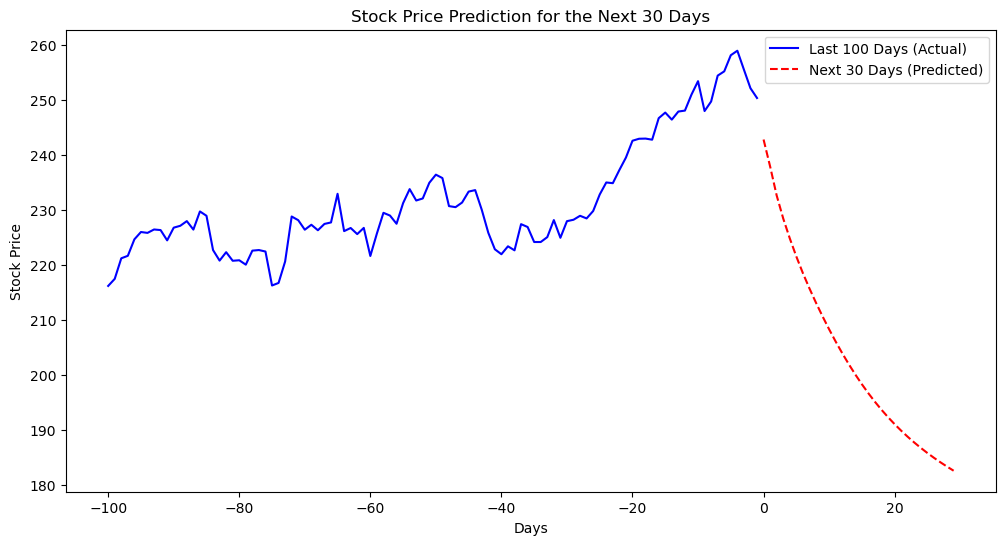

In [47]:
# Get the last 100 actual prices for context
last_100_days_actual = scaler.inverse_transform(test_data_scaled[-100:])

# Create a timeline (last 100 days + next 30 days)
days_past = np.arange(-100, 0)  # Last 100 days (past)
days_future = np.arange(0, 30)  # Next 30 days (future)

plt.figure(figsize=(12, 6))

# Plot last 100 actual stock prices
plt.plot(days_past, last_100_days_actual, label="Last 100 Days (Actual)", color="blue")

# Plot next 30 days predicted stock prices
plt.plot(days_future, future_predictions, label="Next 30 Days (Predicted)", color="red", linestyle="dashed")

# Add labels and title
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price Prediction for the Next 30 Days")

plt.show()